
# Multiclass Image Classification

This notebook demonstrates how to perform multiclass classification on a diverse dataset of images using custom ANN and CNN models, and compare their performance against each other.

To get started, you must have the following requirements installed:

1. tensorflow - to load and preprocess the data, and work with the models
2. numpy - to prepare data during testing
3. matplotlib - to display images in the Jupyter notebook
4. notebook - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's virtualenv package.

First, open a Terminal (Command Prompt on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install tensorflow numpy matplotlib notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```



## Getting Started

The following imports are necessary to work with this notebook:

In [3]:
# Imports

import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, classification_report

## The CIFAR-10 Dataset

We will be working with Alex Krizhevsky's <a href="https://www.cs.toronto.edu/~kriz/cifar.html">**CIFAR-10**</a> dataset.

This is a collection of 60,000 images, each 32x32 pixels, belonging to 10 classes (6,000 images per class):

1. `airplane` (class label `0`)
2. `automobile` (class label `1`)
3. `bird` (class label `2`)
4. `cat` (class label `3`)
5. `deer` (class label `4`)
6. `dog` (class label `5`)
7. `frog` (class label `6`)
8. `horse` (class label `7`)
9. `ship` (class label `8`)
10. `truck` (class label `9`)

The dataset is divided into 6 equal batches (10,000 images each), which is composed of

- 5 training batches (50,000 training images, 5,000 images per class)
- 1 testing batch (10,000 testing images, 1,000 images per class)

The classes are completely mutually exclusive.

For instance, there is no overlap between `automobile` and `truck`. `automobile` includes sedans, SUVs etc. `truck` includes big trucks only.

We can load this dataset from `tensorflow.keras.datasets.cifar10.load_data()`. This returns a tuple of NumPy arrays containing the training and testing data.

In [4]:
# Load the CIFAR10 dataset into memory

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

print(type(X_train))

<class 'numpy.ndarray'>


Let's inspect the shapes of the above NumPy arrays separately.

In [5]:
# Check shapes of NumPy arrays containing CIFAR10 data

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (50000, 32, 32, 3)
Shape of X_test: (10000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of y_test: (10000, 1)


Notice how `y_train` and `y_test` are 2D arrays. These must be transformed into 1D arrays before we begin training and testing our models. This is because models built using the Keras library's `models.Sequential` class expect 1D arrays as the list of labels during training and testing.

In [6]:
# Reshape y_train and y_test into 1D arrays

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

print(f"Shape of y_train after reshaping: {y_train.shape}")
print(f"Shape of y_test after reshaping: {y_test.shape}")

Shape of y_train after reshaping: (50000,)
Shape of y_test after reshaping: (10000,)


Now, let's also take a look at a few images from the dataset itself to see what we are working with.

First, we'll create a list of the classes of images that appear in the dataset. When creating this list, we need to add the classes in the order of increasing class label, i.e. `airplane` first (`0`), then `automobile` (`1`) and so on.

In [7]:
# List of classes (labels) of images in the dataset
# ordered according to their class labels

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Next, let's create a custom function to label and display an image as a Matplotlib plot.

In [8]:
# Function to label and display images

def label_and_display_image(X, y, index):
    # Create a new figure for plotting (15x2 sq. in. size)
    plt.figure(figsize=(15, 2))

    # Display an image from X (dataset) at specified index
    plt.imshow(X[index])

    # Label the image using the `classes` list
    plt.xlabel(classes[y[index]])

We can now view a couple of images from the dataset using the above function.

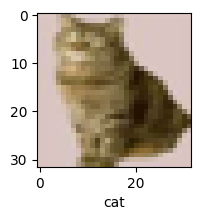

In [9]:
# View the image having index 12225 in the training dataset

label_and_display_image(X_train, y_train, 12225)

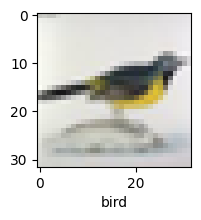

In [10]:
# View the image having index 4811 in the testing dataset

label_and_display_image(X_test, y_test, 4811)

Finally, before training the model, we need to normalize the input data (both training and testing).

This provides multiple benefits. For instance, when input data is normalized to a small range (e.g. 0 to 1), optimization algorithms such as gradient descent can make more effective updates to the weights of a model, leading to faster convergence and more efficient training overall.

This is what the data looks like before normalization:

In [11]:
# Inspect first 3 elements of training data before normalization

X_train[:3]

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

Now, let's normalize the data to between `0` and `1`.

In [12]:
# Normalize training and testing data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Inspect training data after normalization
X_train[:3]

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

## Artificial Neural Networks

Artificial Neural Networks (ANNs) are the most basic form of neural networks.

They contain an input layer, an output layer and any number of hidden ("black-box") layers.

Each layer is made up of **neurons**, connected to neurons in its preceding and succeeding layers. Each connection between neurons has a **weight** associated with it.

Each neuron has a **bias** and an **activation function**. A neuron performs the following tasks:

1. Compute the weighted sum of its inputs,
2. Add a bias to the weighted sum,
3. Apply an activation function to the biased inputs, which yields the output of the neuron.

ANNs are versatile. They can be used for a wide variety of tasks, but they are usually applied in situations where the data has no specific spatial structure (e.g. tabular data).

For our scenario, we will be building an ANN using the `models.Sequential` class from Keras.

This ANN will contain the following layers:

1. An input layer, whose size will be specified in its succeeding layer
2. A `Flatten` layer to convert the input image from a 3D array to a 1D tensor
3. Two `Dense` layers to process the flattened data
4. Another `Dense` layer to produce the final output (a probability distribution over the 10 classes)

In [13]:
# Build the ANN model

ann = models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(3000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

Next, we compile the model to configure it for training.

In [14]:
# Compile the ANN model

ann.compile(
    optimizer="SGD",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

After this, we can train the model on the training data that we prepared and normalized previously.

In [15]:
# Train the ANN model

ann.fit(X_train, y_train, epochs=5)

1563/1563 [==============================] - 67s 42ms/step - loss: 1.8137 - accuracy: 0.3553
Epoch 2/5
1563/1563 [==============================] - 63s 40ms/step - loss: 1.6250 - accuracy: 0.4283
Epoch 3/5
1563/1563 [==============================] - 62s 40ms/step - loss: 1.5423 - accuracy: 0.4577
Epoch 4/5
1563/1563 [==============================] - 62s 40ms/step - loss: 1.4819 - accuracy: 0.4773
Epoch 5/5
1563/1563 [==============================] - 64s 41ms/step - loss: 1.4320 - accuracy: 0.4962


Here, we can observe that the ANN has reached a meager **49.62% training accuracy**. This is as expected, since ANNs do not perform well on complex tasks such as image classification, even when the images are considerably low in size.

To view the ANN's performance on real-world scenarios, we can use it to make predictions on the testing data.

In [16]:
# Get predicted probabilities from ANN model on testing data
y_pred = ann.predict(X_test)

# Convert the predicted probabilities into actual class labels
y_pred_classes = [np.argmax(element) for element in y_pred]

313/313 [==============================] - 2s 7ms/step


Now, we can use the `classification_report()` function from `sklearn.metrics` to view the ANN's performance on the testing data.

In [17]:
# Derive classification report for ANN model

print("Classification Report - ANN\n")
print(classification_report(y_test, y_pred_classes))

Classification Report - ANN

              precision    recall  f1-score   support

           0       0.48      0.66      0.55      1000
           1       0.69      0.52      0.59      1000
           2       0.42      0.26      0.32      1000
           3       0.30      0.50      0.38      1000
           4       0.63      0.16      0.26      1000
           5       0.41      0.33      0.37      1000
           6       0.49      0.57      0.53      1000
           7       0.44      0.68      0.53      1000
           8       0.66      0.59      0.63      1000
           9       0.59      0.55      0.57      1000

    accuracy                           0.48     10000
   macro avg       0.51      0.48      0.47     10000
weighted avg       0.51      0.48      0.47     10000



As expected, the model performs terribly, with an overall **48% testing accuracy**.

To overcome the shortcomings of ANNs, we use other deep learning models, such as **Convolutional Neural Networks**.